## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_diagonal_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/diagonal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4500,
 3: 18000,
 4: 72000,
 5: 288000,
 6: 1152000,
 7: 4608000,
 8: 18432000,
 9: 73728000,
 10: 294912000}

Running 12760 CDFs


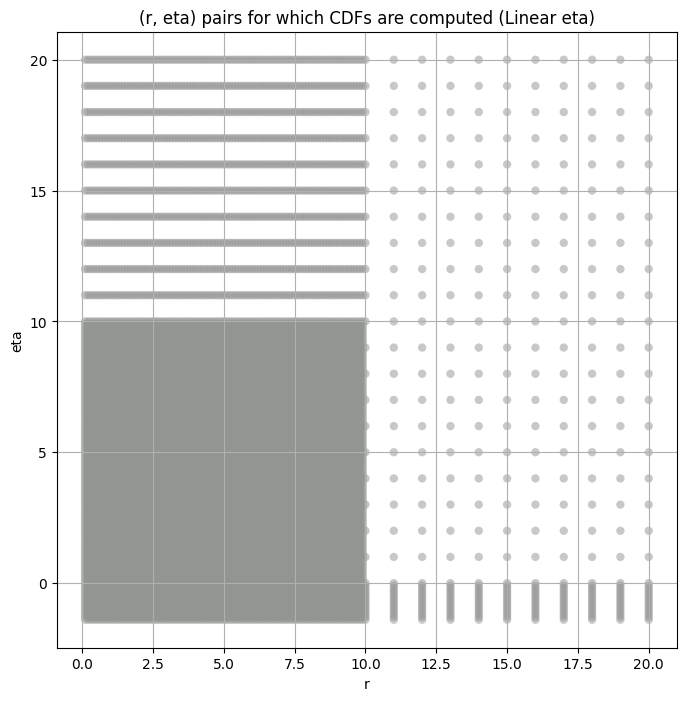

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      69813.110000  24438.908000  133779.030000   429.18650  234.234560   
3      11392.441000   6152.593300   18595.248000   457.30783  219.685730   
4       2179.918000   1035.629800    3992.716800   704.63410  168.132600   
5        346.023830    167.539300     702.062500   935.48710   96.572205   
6         86.537060     41.918427     230.855830  1742.35450   77.560530   
7         26.342790     13.104974      79.347130  2298.49900   57.908700   
8         10.249555      4.653888      33.031303  3021.93630   66.716064   
9          1.900417      0.877120       6.467205  3454.85030   64.006880   
10         0.176650      0.072993       0.811862  6309.32670   72.034730   

       kurt_upper  total_samples  
layer                             
2       710.59045         4500.0  
3       702.85030        18000.0  
4      1193.39250        72000.0  
5      1871.04700       288000.0  
6      3937.45390      1152000.0  
7      4520.91500      4608000.0  
8      4910.34400     18432000.0  
9      5167.04400     73728000.0  
10     6579.15430    294912000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      69813.110000   69813.109375     9920.623047     7953.947266   
3      11392.441000   11392.441406     3032.124756     2423.071533   
4       2179.918000    2179.917969      955.798767      736.002563   
5        346.023830     346.023834      172.743378      143.191498   
6         86.537060      86.537064       43.356174       36.672462   
7         26.342790      26.342791       13.506333       11.733610   
8         10.249555      10.249555        4.816904        4.138035   
9          1.900417       1.900417        0.911122        0.787220   
10         0.176650       0.176650        0.076388        0.065326   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         6690.400879      5774.506836      4532.399414      3643.500488   
3         2126.888428      1923.112549      1640.430054      1453.139038   
4          636.744568       581.160339       510.694275       463.291077   
5          128.851730       119.595314       107.232193        99.003235   
6           33.324631        31.228121        28.536779        26.764936   
7           10.819759        10.221109         9.447954         8.934705   
8            3.799352         3.581938         3.299913         3.112365   
9            0.722278         0.679948         0.624244         0.586241   
10           0.059554         0.055786         0.050793         0.047363   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          2986.893555      2496.479492      2114.549561      1353.090332  
3          1300.449829      1177.351807      1077.406250       857.250977  
4           428.856445       401.444244       379.020264       328.649292  
5            92.795265        87.780624        83.669182        74.345390  
6            25.436453        24.370810        23.476955        21.443718  
7             8.549770         8.239986         7.980681         7.381248  
8             2.972240         2.860004         2.765742         2.547710  
9             0.557087         0.533308         0.513147         0.466021  
10            0.044717         0.042548         0.040703         0.036376

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0354506753007825 69813.11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.015561913660280258 9920.623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.018456060436917276 7953.9473


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.02448393212736144 6690.401


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.02978923489411245 5774.507


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.03844689193618245 4532.3994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.04984157583329018 3643.5005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.06181964938987282 2986.8936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.07230312333212444 2496.4795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.08275780422109003 2114.5496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.1143432700036357 1353.0903
Number of samples: 4500, Without approximation : 4500.0


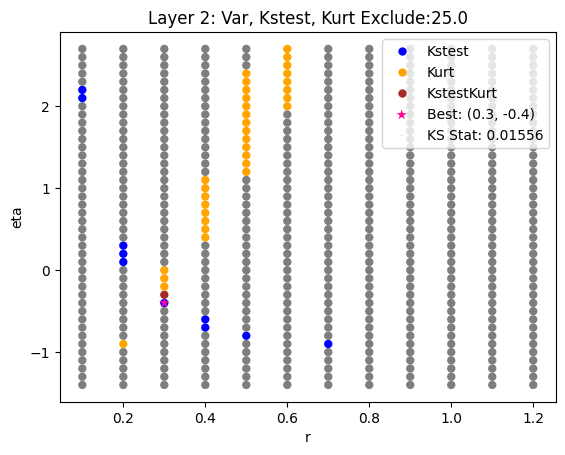

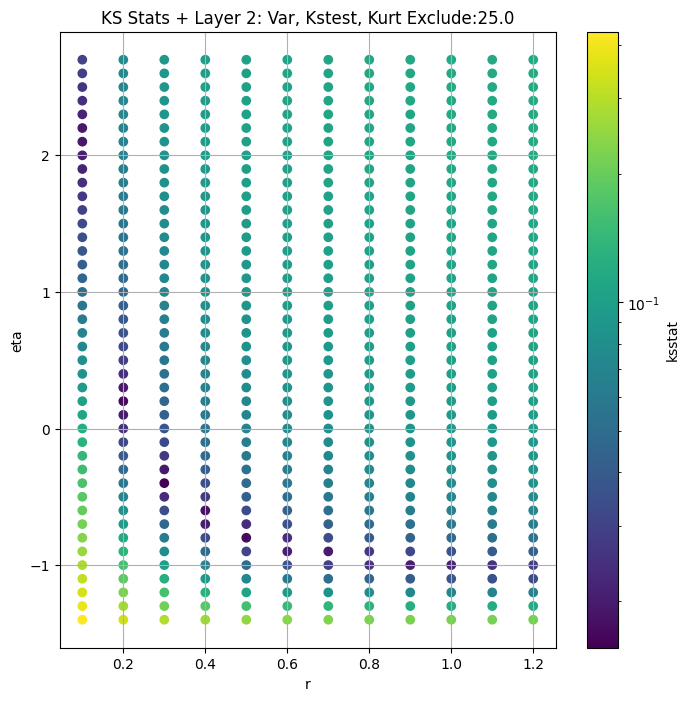

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.033177781418438745 11392.441


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.014405668232048696 3032.1248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.010200657190156226 2423.0715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.010557793035036678 2126.8884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.010919619684361441 1923.1125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.01340746008775336 1640.43


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.01592358576227708 1453.139


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.018704122893654442 1300.4498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.021371151387597098 1177.3518


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.024314171327787088 1077.4062


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.03317875907067355 857.251
Number of samples: 18000, Without approximation : 18000.0


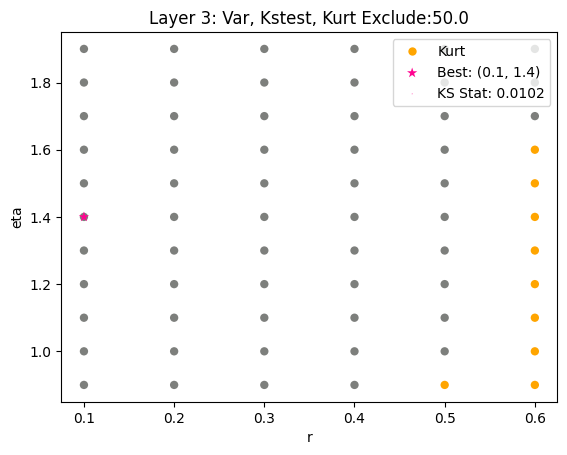

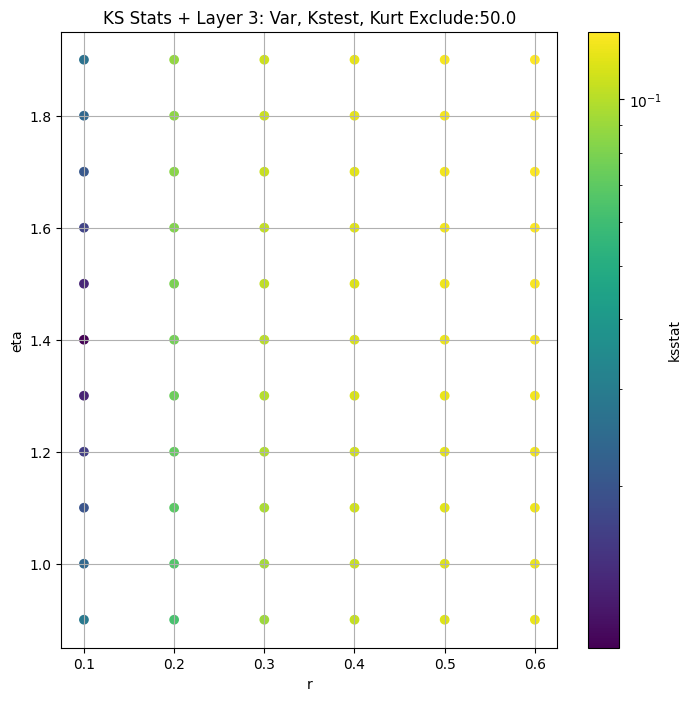

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03659838142726213 2179.918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.02245121234045233 955.79877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.017941594840913594 736.00256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.015297492205839425 636.74457


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.012462059304410689 581.16034


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.011370895040177298 510.69427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.00946321829215735 463.29108


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.007627120162575718 428.85645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.00871600478032375 401.44424


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.009177864361206933 379.02026


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.011647022639198035 328.6493
Number of samples: 72000, Without approximation : 72000.0


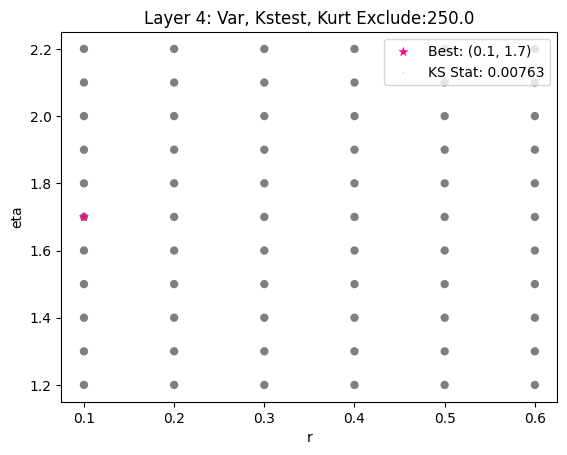

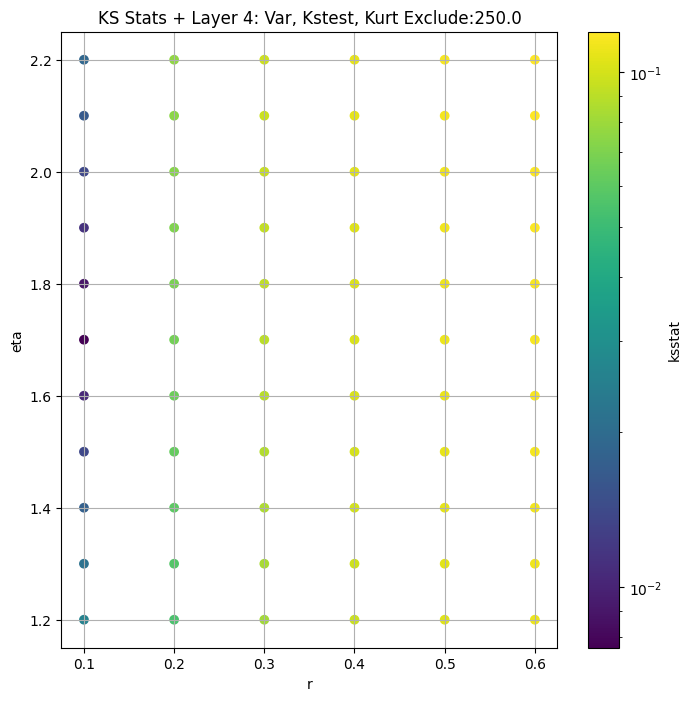

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.031825676570146566 346.02383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.01908935469334133 172.74338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.014509427809437522 143.1915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.011814809600362325 128.85173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.01051955753336209 119.595314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.008211808231823173 107.23219


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.005733117033014962 99.003235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.004171755832437896 92.795265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.004795721606749792 87.780624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.0054158005078029925 83.66918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.0070448147321197085 74.34539
Number of samples: 100000, Without approximation : 288000.0


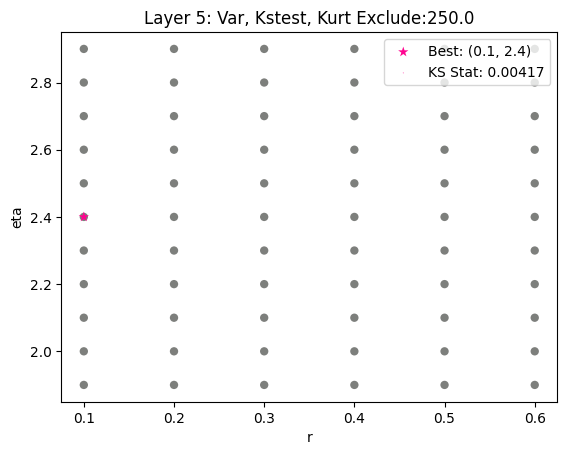

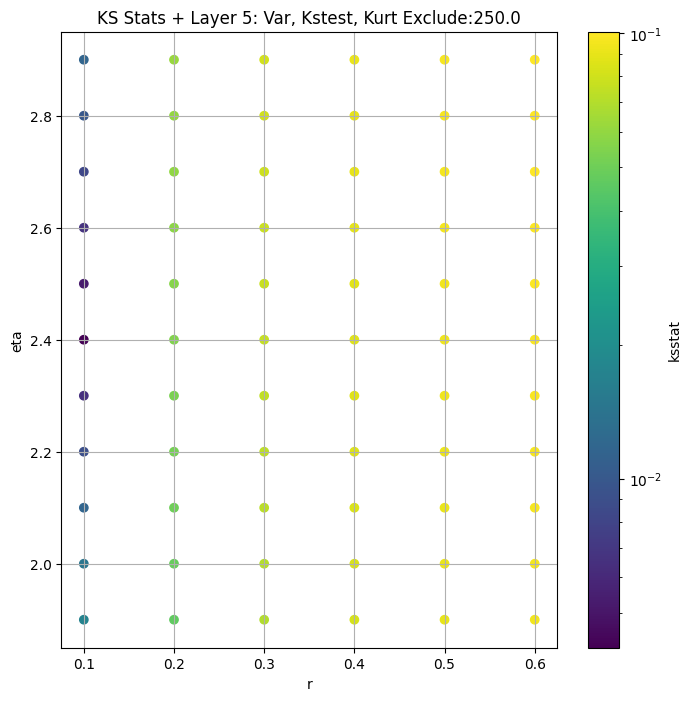

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.028046889692146748 86.53706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01301970753959747 43.356174


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.009255566169397822 36.672462


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.006525505671188925 33.32463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.004922867857420632 31.22812


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.002513701917371991 28.53678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0028496633725572096 26.764936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.0034886382025609564 25.436453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.004065206691775125 24.37081


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.004673605067088249 23.476955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.006652340987292948 21.443718
Number of samples: 100000, Without approximation : 1152000.0


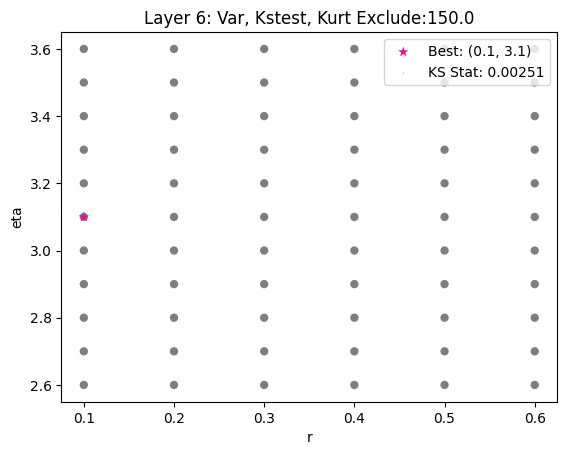

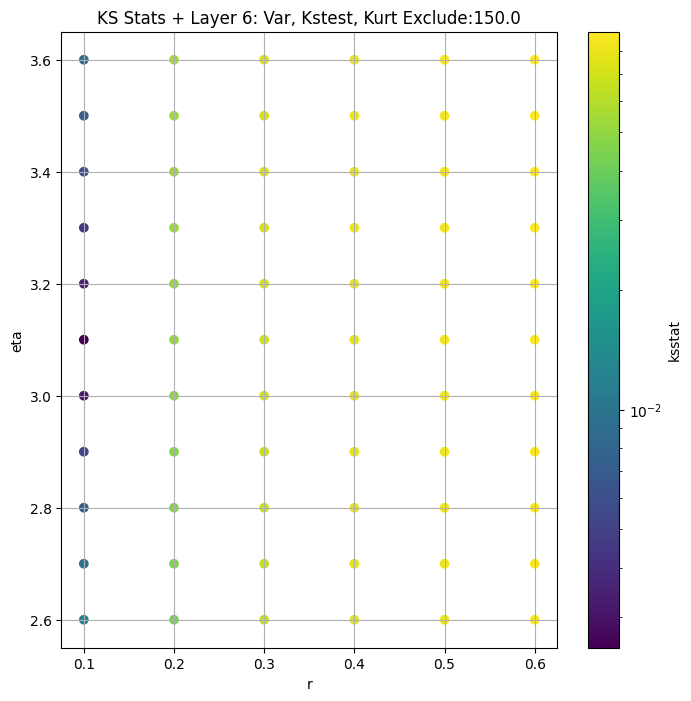

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.02492092946405744 26.34279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.009372040513204727 13.506333


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.0056962431387233 11.73361


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.0037269681376211894 10.819759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.0022381205924081327 10.221109


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0020647793016389526 9.447954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0026816297264340844 8.934705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.003390528788809683 8.54977


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.004051412311547986 8.239986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.004771655443985839 7.980681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.006760471387755755 7.3812475
Number of samples: 100000, Without approximation : 4608000.0


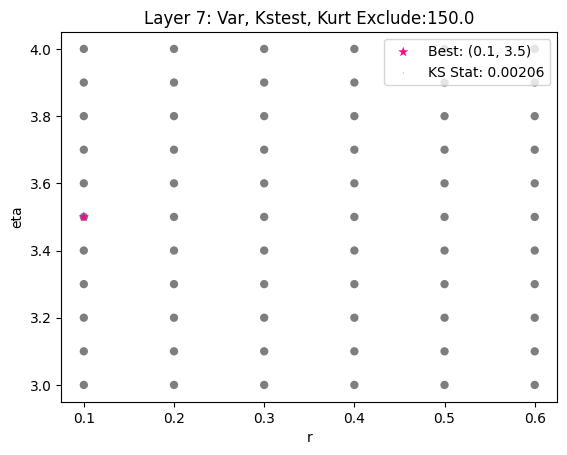

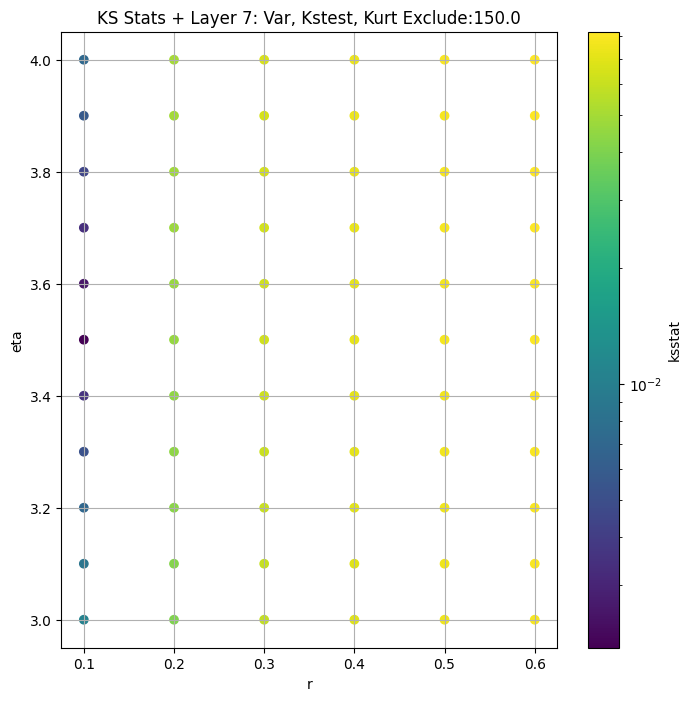

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.02662129126218682 10.249555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.010417778757512694 4.8169036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006019249132102417 4.1380353


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.004033049771573594 3.799352


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.002748363227981887 3.5819376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0020827990125786844 3.2999134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.002845607132272443 3.1123645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.003572302677875566 2.9722397


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.004395831006833469 2.8600042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005039903259524081 2.765742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.006985967945900229 2.5477104
Number of samples: 100000, Without approximation : 18432000.0


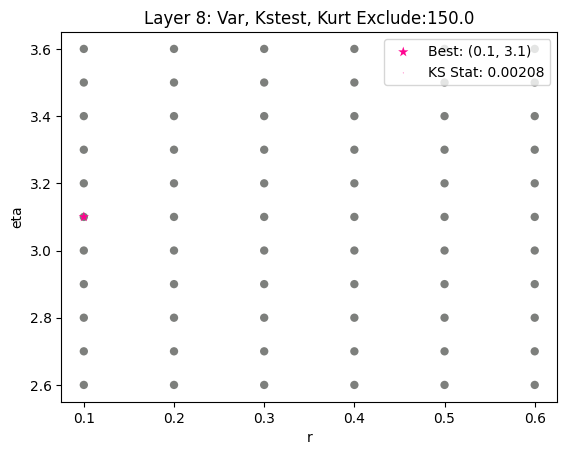

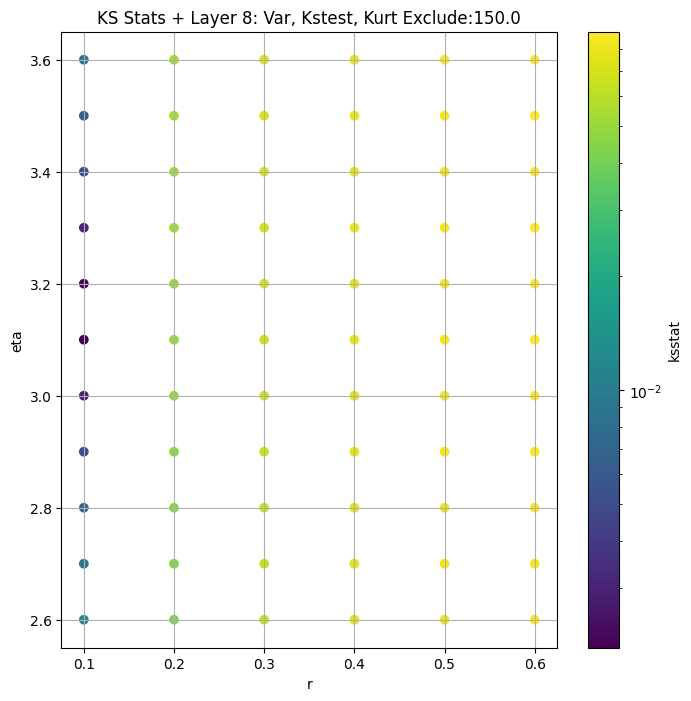

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.02606357644309093 1.9004169


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.013101429535003317 0.91112226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.009969835467171728 0.78722006


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.008058660496611678 0.7222784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006040837803196308 0.6799481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.005036540181918042 0.62424415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.003943708390710232 0.58624077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.00493913174992644 0.55708706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.005342395240455877 0.5333079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.0061796710468101645 0.5131468


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007639450602983655 0.4660209
Number of samples: 100000, Without approximation : 73728000.0


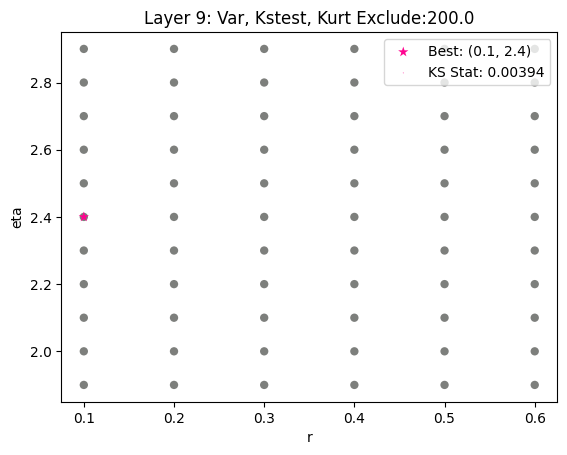

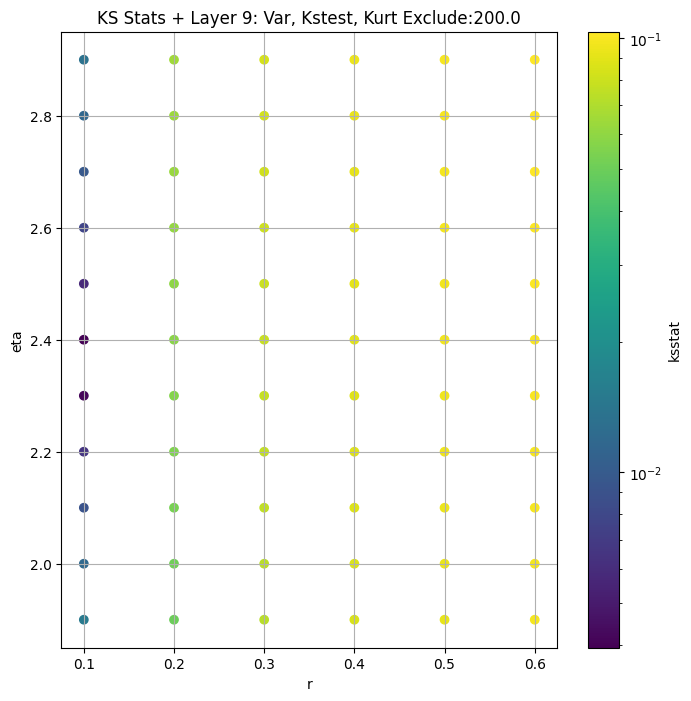

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.03080403497076352 0.17664976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.018898372859299573 0.076387905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.015536431535415965 0.06532602


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.012525632895506372 0.059554294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.011630473846572897 0.055786382


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.010172229496485302 0.05079305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.009167093772015966 0.047362704


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.008767080812084771 0.044717338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.007511872371807143 0.042548336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.007522637922955343 0.040702686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.00903493677363449 0.03637639
Number of samples: 100000, Without approximation : 294912000.0


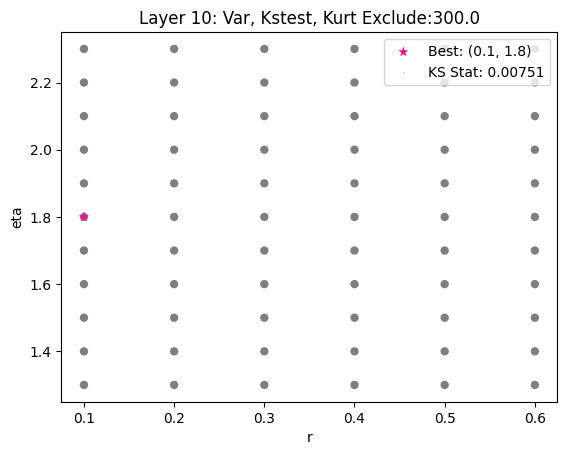

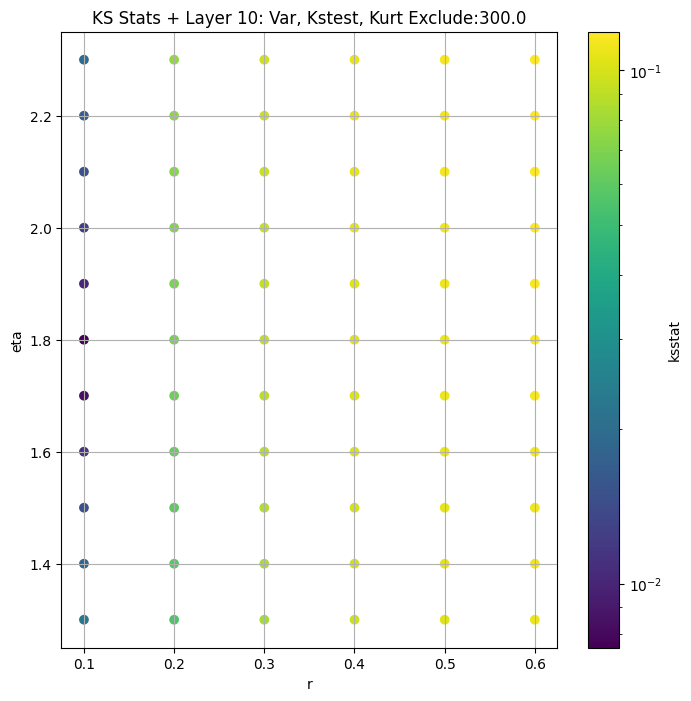

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      69813.110000  24438.908000  133779.030000   429.18650  234.234560   
3      11392.441000   6152.593300   18595.248000   457.30783  219.685730   
4       2179.918000   1035.629800    3992.716800   704.63410  168.132600   
5        346.023830    167.539300     702.062500   935.48710   96.572205   
6         86.537060     41.918427     230.855830  1742.35450   77.560530   
7         26.342790     13.104974      79.347130  2298.49900   57.908700   
8         10.249555      4.653888      33.031303  3021.93630   66.716064   
9          1.900417      0.877120       6.467205  3454.85030   64.006880   
10         0.176650      0.072993       0.811862  6309.32670   72.034730   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       710.59045         4500.0             0.015562        0.3         -0.4   
3       702.85030        18000.0             0.010201        0.1          1.4   
4      1193.39250        72000.0             0.007627        0.1          1.7   
5      1871.04700       288000.0             0.004172        0.1          2.4   
6      3937.45390      1152000.0             0.002514        0.1          3.1   
7      4520.91500      4608000.0             0.002065        0.1          3.5   
8      4910.34400     18432000.0             0.002083        0.1          3.1   
9      5167.04400     73728000.0             0.003944        0.1          2.4   
10     6579.15430    294912000.0             0.007512        0.1          1.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       5.528269e+01                    25.0         9920.623000   
3       1.412494e-12                    50.0         2423.071500   
4       1.054156e-13                   250.0          428.856450   
5       3.909647e-15                   250.0           92.795265   
6       2.688661e-16                   150.0           28.536780   
7       4.143993e-17                   150.0            9.447954   
8       3.109093e-17                   150.0            3.299913   
9       2.469947e-17                   200.0            0.586241   
10      7.968491e-18                   300.0            0.042548   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.020208  
3                     0.010113  
4                     0.005059  
5                     0.002530  
6                     0.001265  
7                     0.000633  
8                     0.000316  
9                     0.000158  
10                    0.000079

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.036159880869740056, var: 5091.2724609375


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.03097797277550335, var: 5774.5068359375


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.025669906504589668, var: 6690.40087890625


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.019673074882452957, var: 7953.947265625


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.014216496528676736, var: 9920.623046875


  0%|          | 0/1269 [00:00<?, ?it/s]

Finding Minimum after computing 1269 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.031775742481693625, var: 69813.109375
Number of samples: 4500, Without approximation : 4500.0


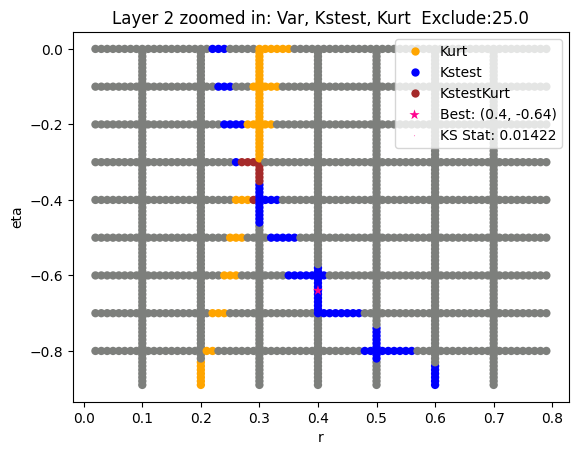

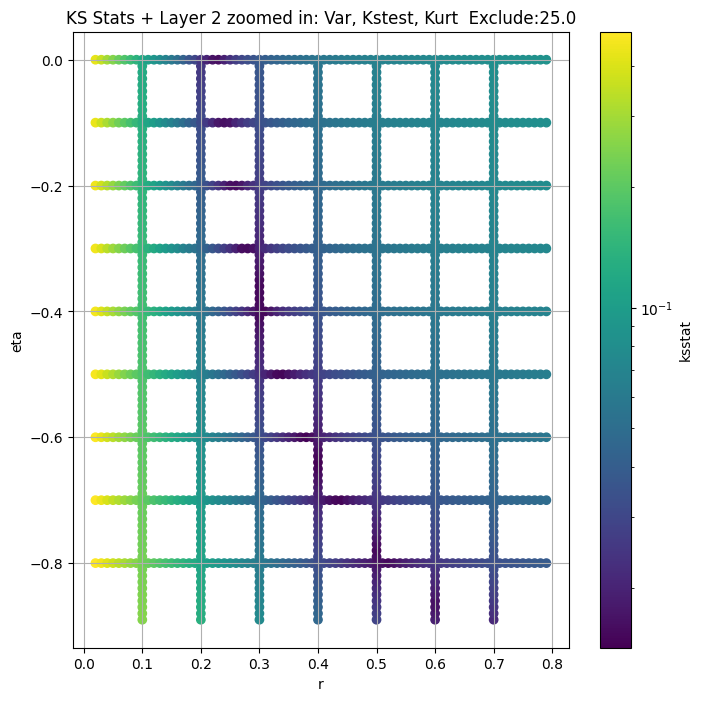

Layer 3


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 50.0 + 100 = 150, ksstat: 0.015902818297330208, var: 1640.4300537109375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 50.0 + 75 = 125, ksstat: 0.01400332272271547, var: 1764.1715087890625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 50.0 + 50 = 100, ksstat: 0.0117847596807025, var: 1923.112548828125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 50.0 + 25 = 75, ksstat: 0.009679777494516519, var: 2126.888427734375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 50.0 + 0 = 50, ksstat: 0.010200657190156226, var: 2423.071533203125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 50.0 + -25 = 25, ksstat: 0.013040997582189073, var: 3032.124755859375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 50.0 + -50 = 0, ksstat: 0.027840923469159118, var: 11392.44140625
Number of samples: 18000, Without approximation : 18000.0


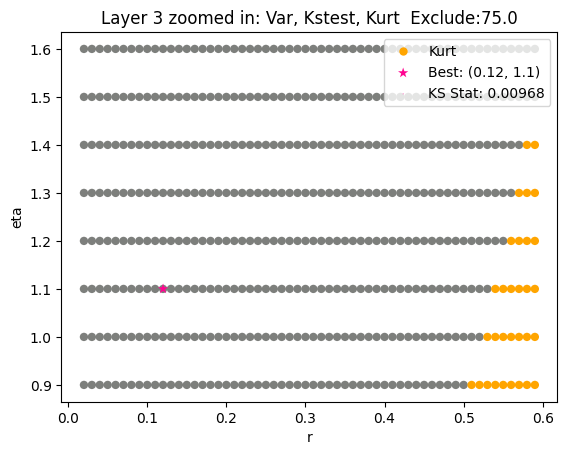

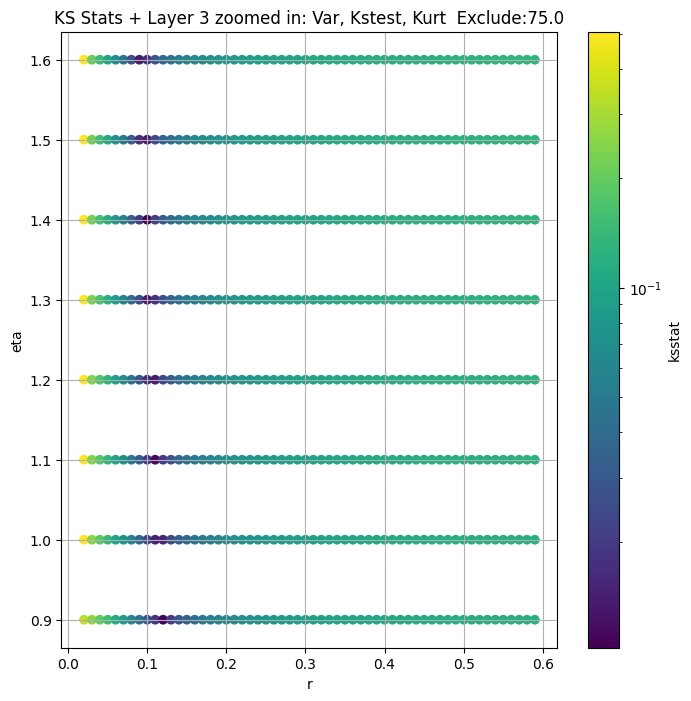

Layer 4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + 100 = 350, ksstat: 0.009611354046812681, var: 379.020263671875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + 75 = 325, ksstat: 0.009183275498284682, var: 389.77288818359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + 50 = 300, ksstat: 0.008622386374716906, var: 401.4442443847656


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + 25 = 275, ksstat: 0.008095898205073837, var: 414.3990478515625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + 0 = 250, ksstat: 0.007579883730588488, var: 428.8564453125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + -25 = 225, ksstat: 0.007222340797640059, var: 444.89984130859375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + -50 = 200, ksstat: 0.007928892816746691, var: 463.29107666015625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + -75 = 175, ksstat: 0.00891050245886818, var: 484.9965515136719


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 250.0 + -100 = 150, ksstat: 0.009531489429210449, var: 510.69427490234375
Number of samples: 72000, Without approximation : 72000.0


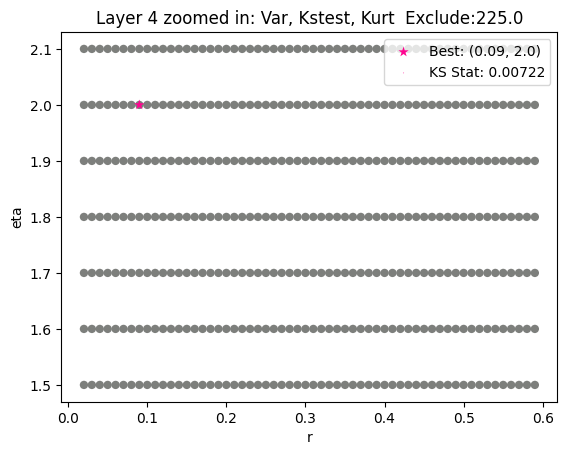

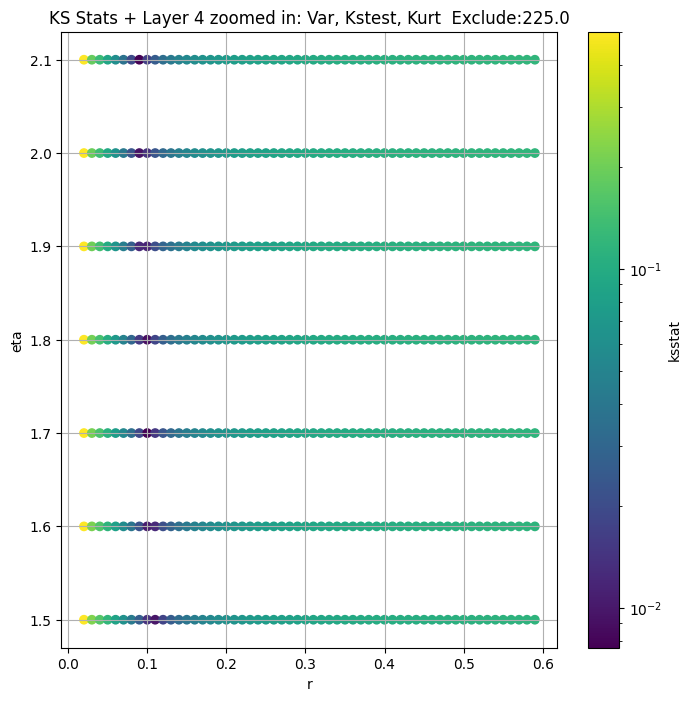

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 100 = 350, ksstat: 0.005434884380795979, var: 83.66918182373047


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 75 = 325, ksstat: 0.005095903897605614, var: 85.62997436523438


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 50 = 300, ksstat: 0.004780010349408781, var: 87.78062438964844


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 25 = 275, ksstat: 0.00447592256634477, var: 90.17156219482422


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 0 = 250, ksstat: 0.004171755832437896, var: 92.7952651977539


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -25 = 225, ksstat: 0.0047667929995085095, var: 95.70304107666016


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -50 = 200, ksstat: 0.00571721514069351, var: 99.00323486328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -75 = 175, ksstat: 0.006206154285750429, var: 102.76853942871094


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -100 = 150, ksstat: 0.007690577586982411, var: 107.23219299316406
Number of samples: 100000, Without approximation : 288000.0


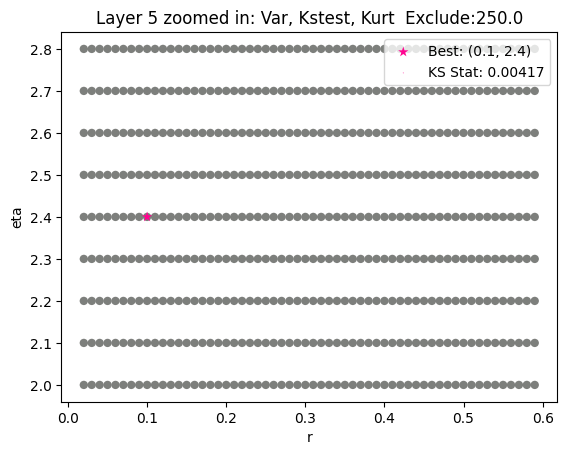

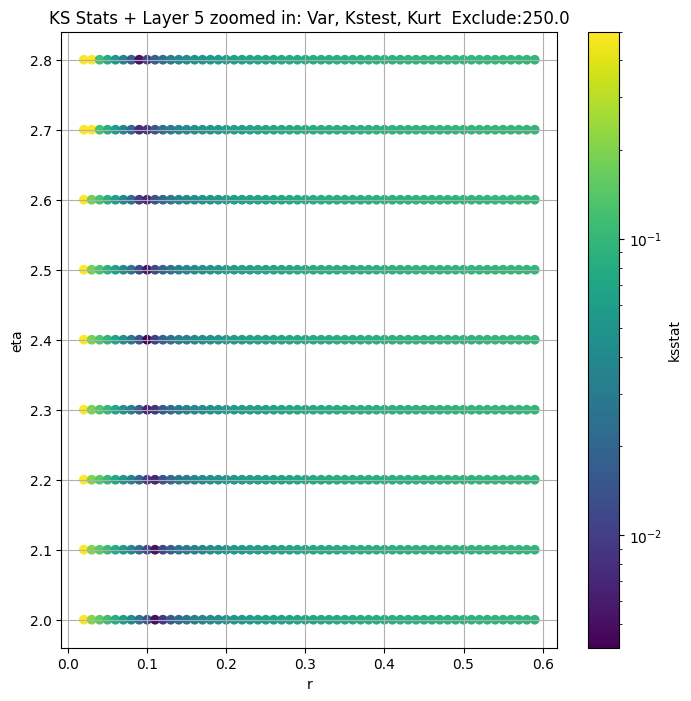

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.0034856532972669108, var: 25.436452865600586


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.003137748767542298, var: 26.0617733001709


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.0028496633725572096, var: 26.764936447143555


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.0025940202546614888, var: 27.57714080810547


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.002513701917371991, var: 28.536779403686523


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.003274331516547213, var: 29.715320587158203


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.004475276700986852, var: 31.228120803833008


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.005754735734334271, var: 33.32463073730469


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.008221921892717532, var: 36.672462463378906
Number of samples: 100000, Without approximation : 1152000.0


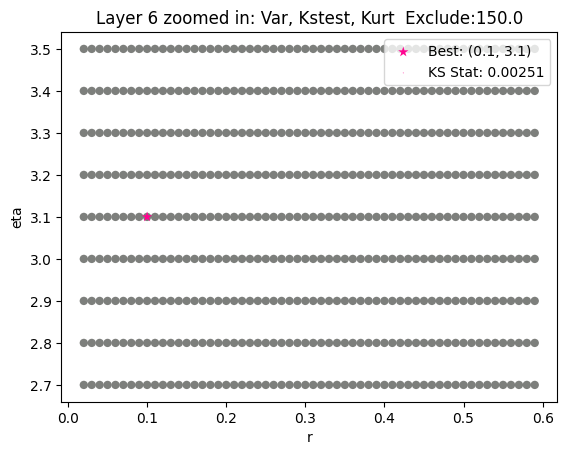

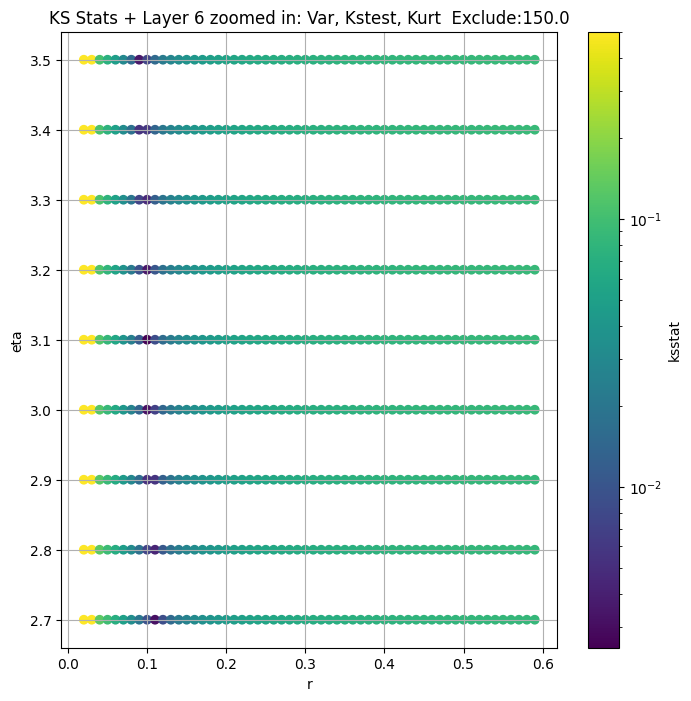

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.004015110579507444, var: 8.54977035522461


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.003394192722297573, var: 8.730846405029297


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.002993074349331104, var: 8.934704780578613


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.0023507615529283488, var: 9.170015335083008


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.0020647793016389526, var: 9.447954177856445


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.0019482780351983697, var: 9.786372184753418


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.0017580548526531237, var: 10.221109390258789


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.003403467105973612, var: 10.819759368896484


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.005435770053872746, var: 11.733610153198242
Number of samples: 100000, Without approximation : 4608000.0


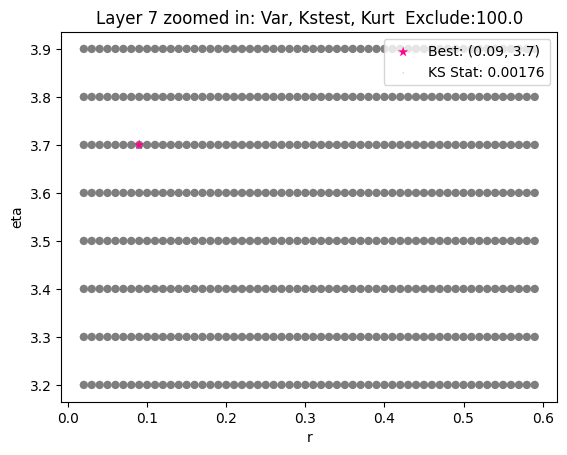

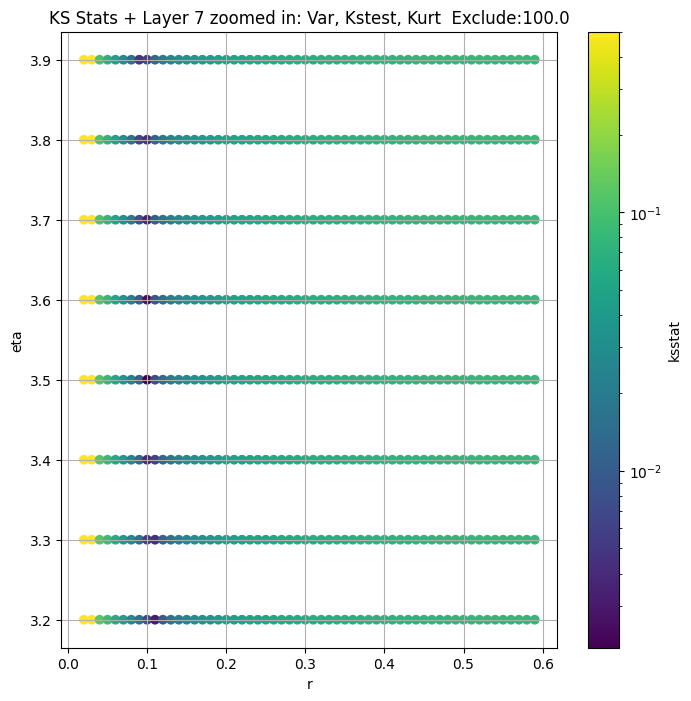

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.004097752850114711, var: 2.9722397327423096


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.0035441910357313366, var: 3.03792405128479


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.003019674565395536, var: 3.1123645305633545


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.002505480500596846, var: 3.1983673572540283


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.0020827990125786844, var: 3.2999134063720703


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.0017748401176227667, var: 3.423624038696289


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.002453276703563101, var: 3.581937551498413


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.0036805622516151715, var: 3.799351930618286


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.005576064115039886, var: 4.138035297393799
Number of samples: 100000, Without approximation : 18432000.0


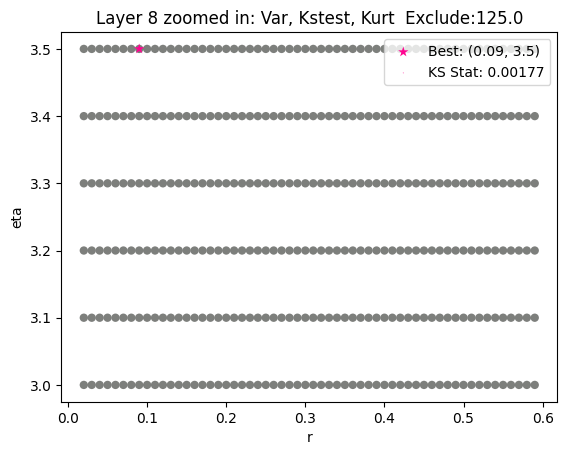

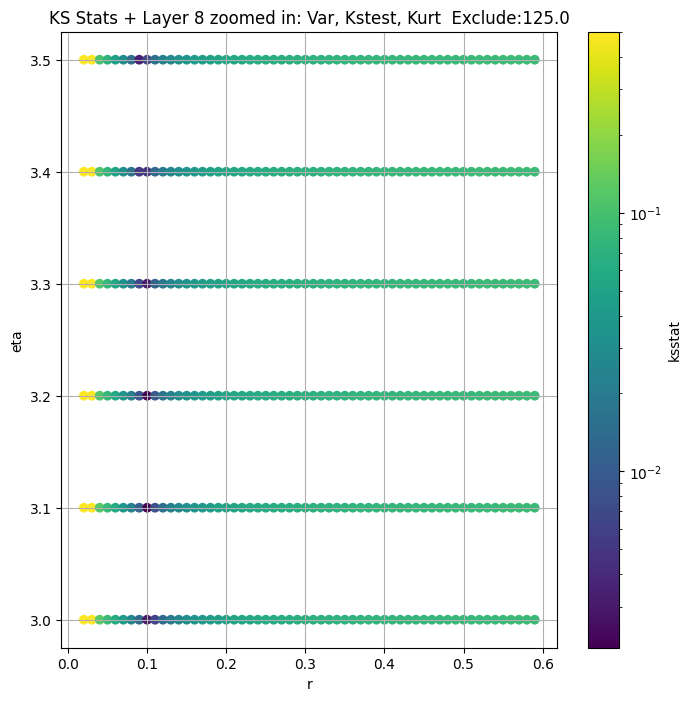

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.005721140937431923, var: 0.5333079099655151


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.005278591928948195, var: 0.5446603894233704


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.004879812510382053, var: 0.5570870637893677


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.004398722329825966, var: 0.5708328485488892


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.0038953463468810456, var: 0.5862407684326172


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.0034785864249913256, var: 0.6037919521331787


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.004132385380716891, var: 0.6242441534996033


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.005324925702562017, var: 0.6488603949546814


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.005732895130128646, var: 0.679948091506958
Number of samples: 100000, Without approximation : 73728000.0


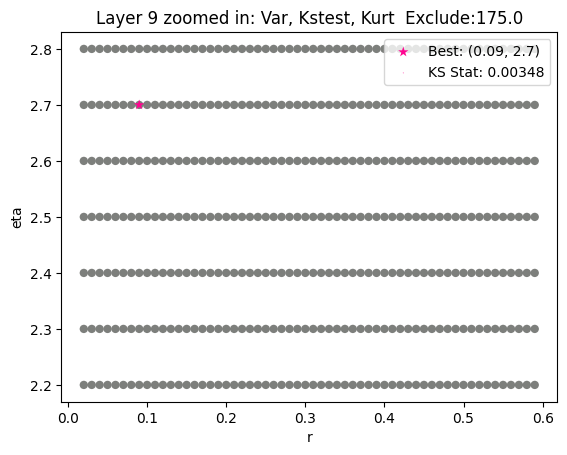

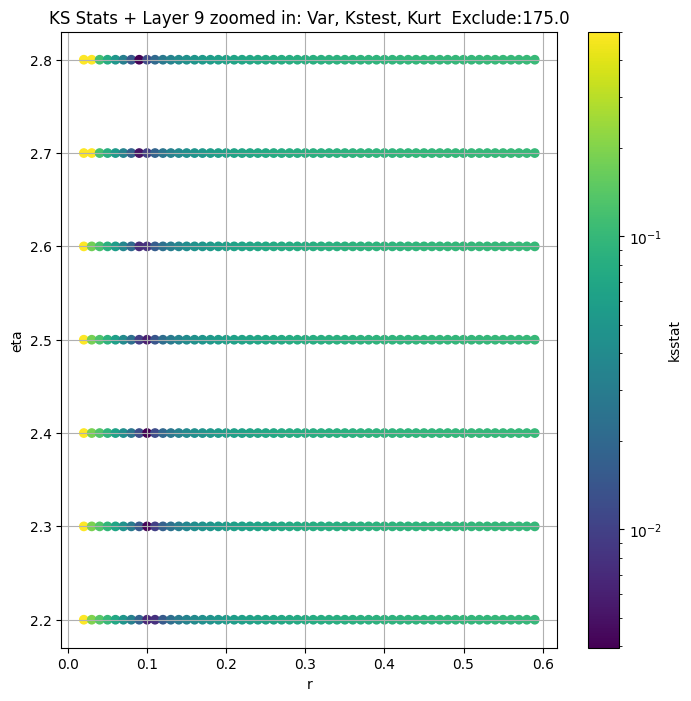

Layer 10


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + 100 = 400, ksstat: 0.008120126097670915, var: 0.039092402905225754


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + 75 = 375, ksstat: 0.007844049950631305, var: 0.03987208381295204


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + 50 = 350, ksstat: 0.0074984304751699, var: 0.040702685713768005


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + 25 = 325, ksstat: 0.007056487222746766, var: 0.041591618210077286


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + 0 = 300, ksstat: 0.007377877392454046, var: 0.04254833608865738


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + -25 = 275, ksstat: 0.006963463329714398, var: 0.043585021048784256


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + -50 = 250, ksstat: 0.007781547078215434, var: 0.04471733793616295


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + -75 = 225, ksstat: 0.008270307342464839, var: 0.04596656560897827


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 10, 300.0 + -100 = 200, ksstat: 0.008470390904710245, var: 0.04736270383000374
Number of samples: 100000, Without approximation : 294912000.0


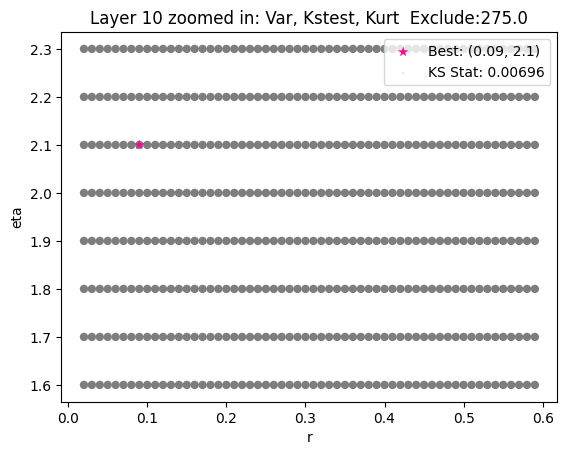

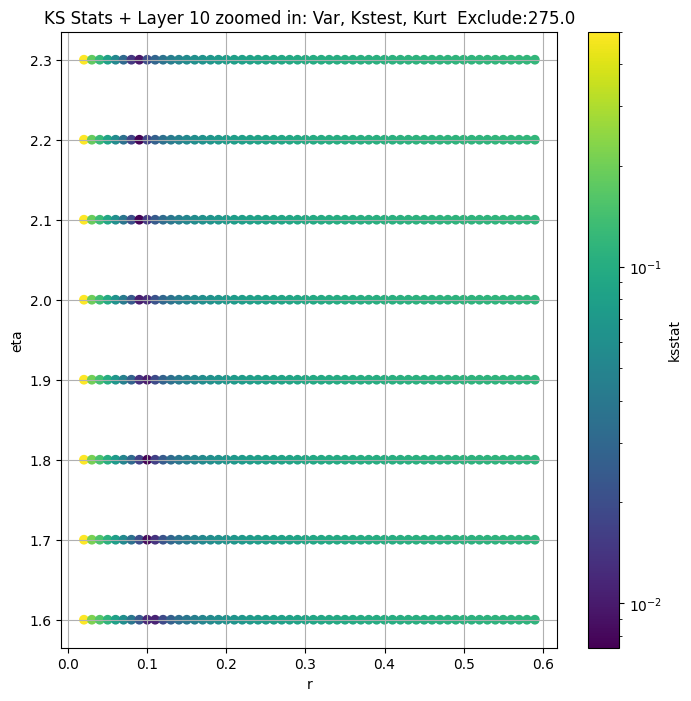

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      69813.110000  24438.908000  133779.030000   429.18650  234.234560   
3      11392.441000   6152.593300   18595.248000   457.30783  219.685730   
4       2179.918000   1035.629800    3992.716800   704.63410  168.132600   
5        346.023830    167.539300     702.062500   935.48710   96.572205   
6         86.537060     41.918427     230.855830  1742.35450   77.560530   
7         26.342790     13.104974      79.347130  2298.49900   57.908700   
8         10.249555      4.653888      33.031303  3021.93630   66.716064   
9          1.900417      0.877120       6.467205  3454.85030   64.006880   
10         0.176650      0.072993       0.811862  6309.32670   72.034730   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       710.59045         4500.0             0.015562        0.3         -0.4   
3       702.85030        18000.0             0.010201        0.1          1.4   
4      1193.39250        72000.0             0.007627        0.1          1.7   
5      1871.04700       288000.0             0.004172        0.1          2.4   
6      3937.45390      1152000.0             0.002514        0.1          3.1   
7      4520.91500      4608000.0             0.002065        0.1          3.5   
8      4910.34400     18432000.0             0.002083        0.1          3.1   
9      5167.04400     73728000.0             0.003944        0.1          2.4   
10     6579.15430    294912000.0             0.007512        0.1          1.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       5.528269e+01                    25.0         9920.623047   
3       1.412494e-12                    50.0         2126.888428   
4       1.054156e-13                   250.0          444.899841   
5       3.909647e-15                   250.0           92.795265   
6       2.688661e-16                   150.0           28.536780   
7       4.143993e-17                   150.0           10.221109   
8       3.109093e-17                   150.0            3.423624   
9       2.469947e-17                   200.0            0.603792   
10      7.968491e-18                   300.0            0.043585   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.020208          0.014216    0.40     -0.64   
3                     0.010113          0.009680    0.12      1.10   
4                     0.005059          0.007222    0.09      2.00   
5                     0.002530          0.004172    0.10      2.40   
6                     0.001265          0.002514    0.10      3.10   
7                     0.000633          0.001758    0.09      3.70   
8                     0.000316          0.001775    0.09      3.50   
9                     0.000158          0.003479    0.09      2.70   
10                    0.000079          0.006963    0.09      2.10   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      7.409961e+02                 25.0         9607  
3      4.431170e-09                 75.0        20250  
4      2.550257e-16                225.0        36000  
5      3.909647e-15                250.0       108000  
6      2.688661e-16                150.0       288000  
7      1.086073e-19                100.0       576000  
8      5.433363e-20                125.0       576000  
9      5.613902e-20                175.0       153772  
10     1.890336e-20                275.0        38442

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

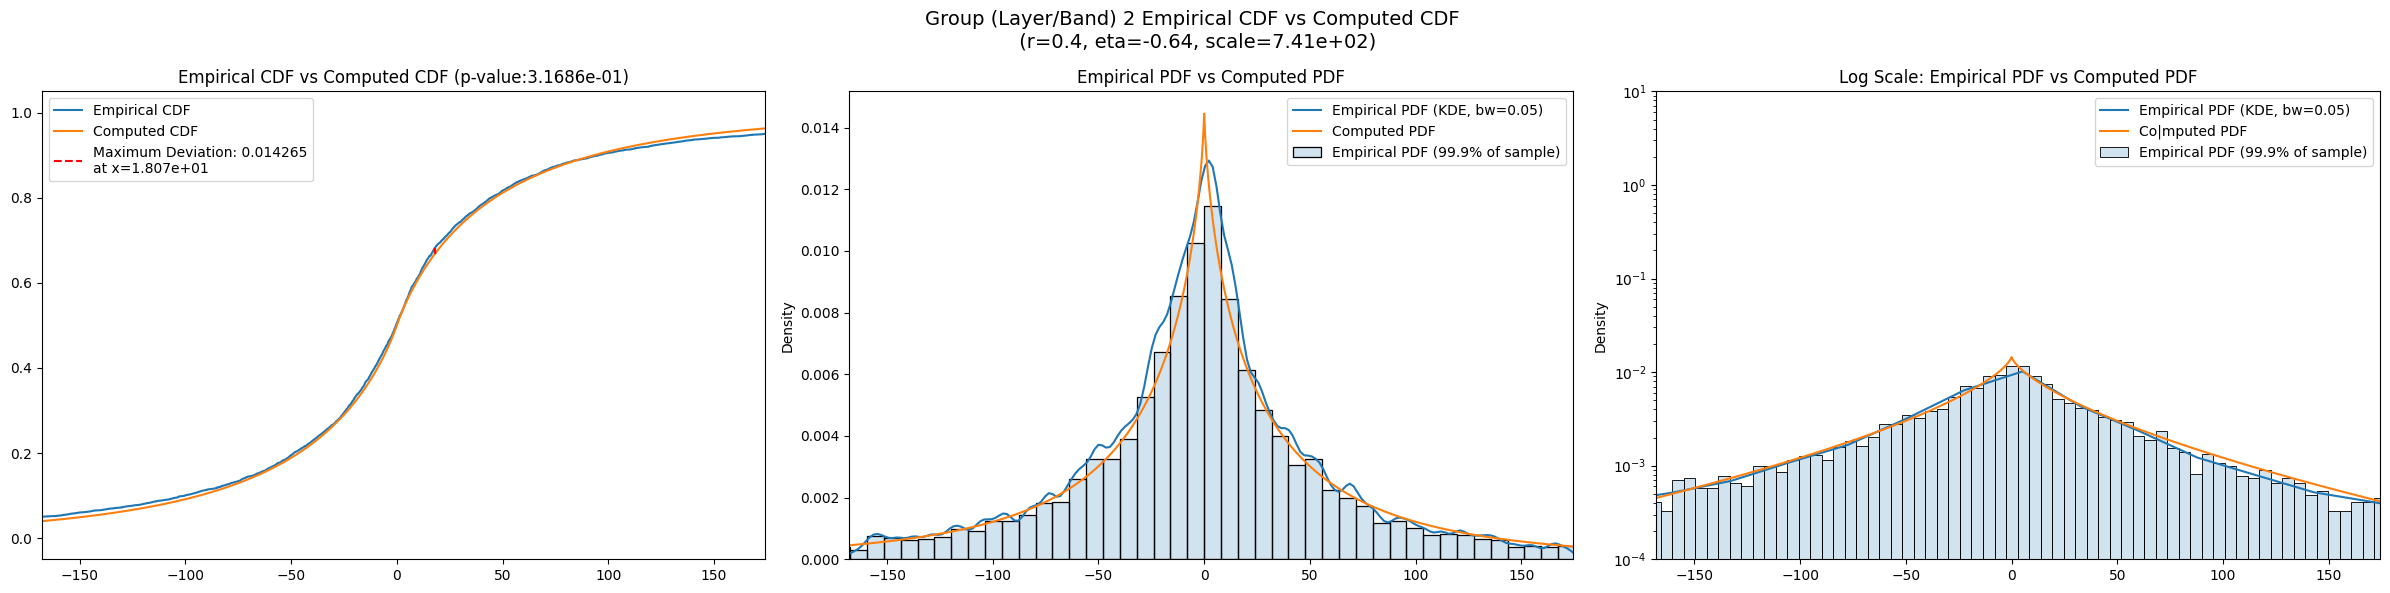

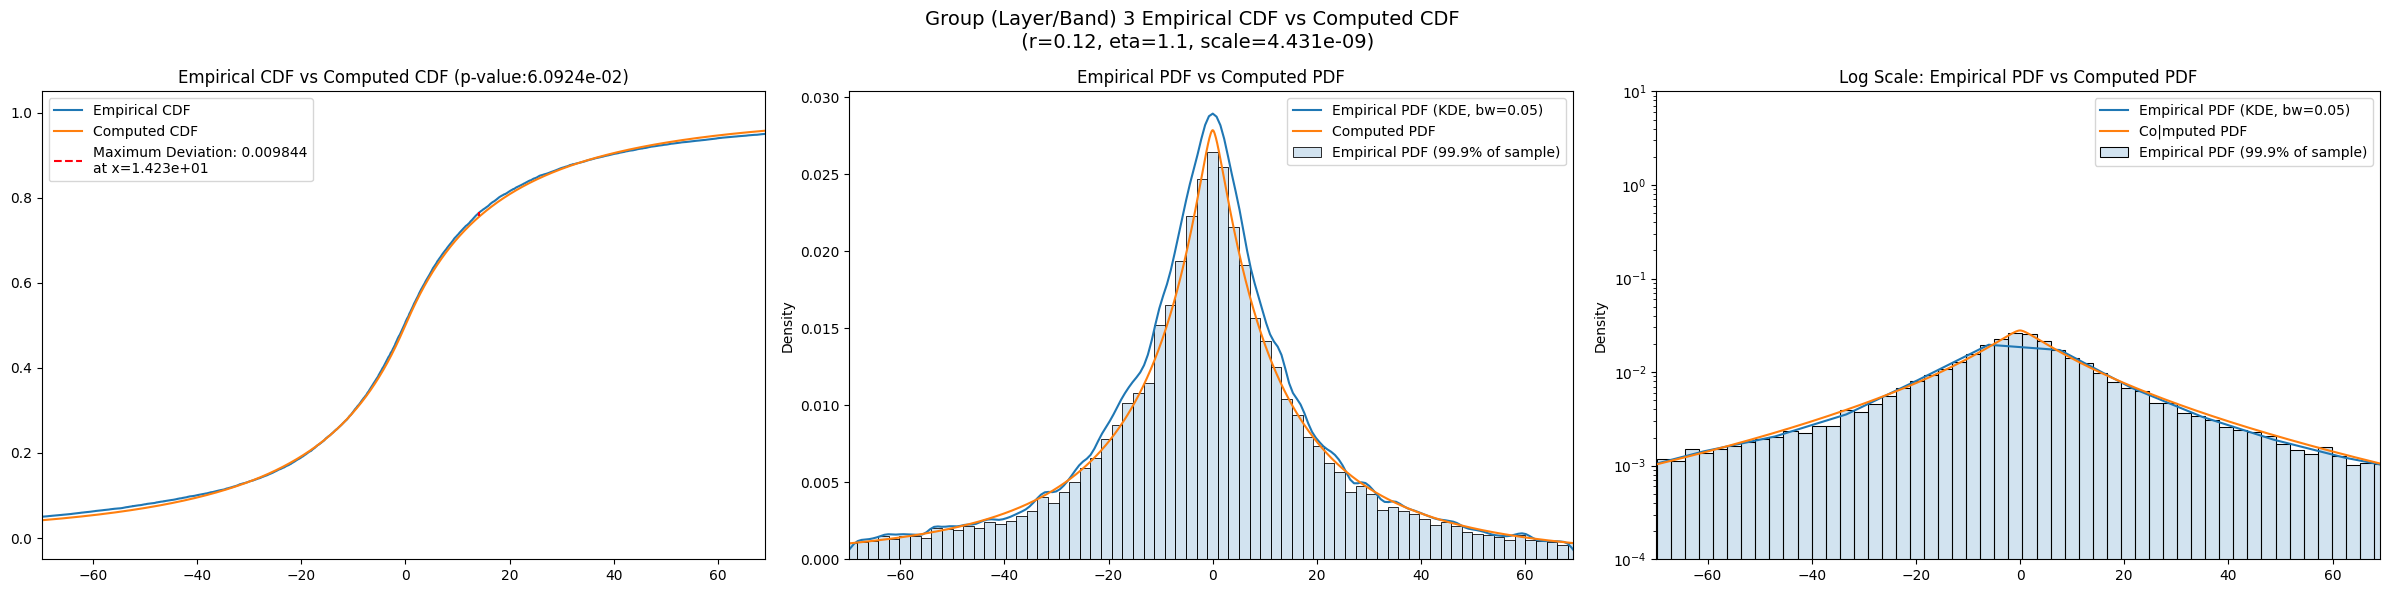

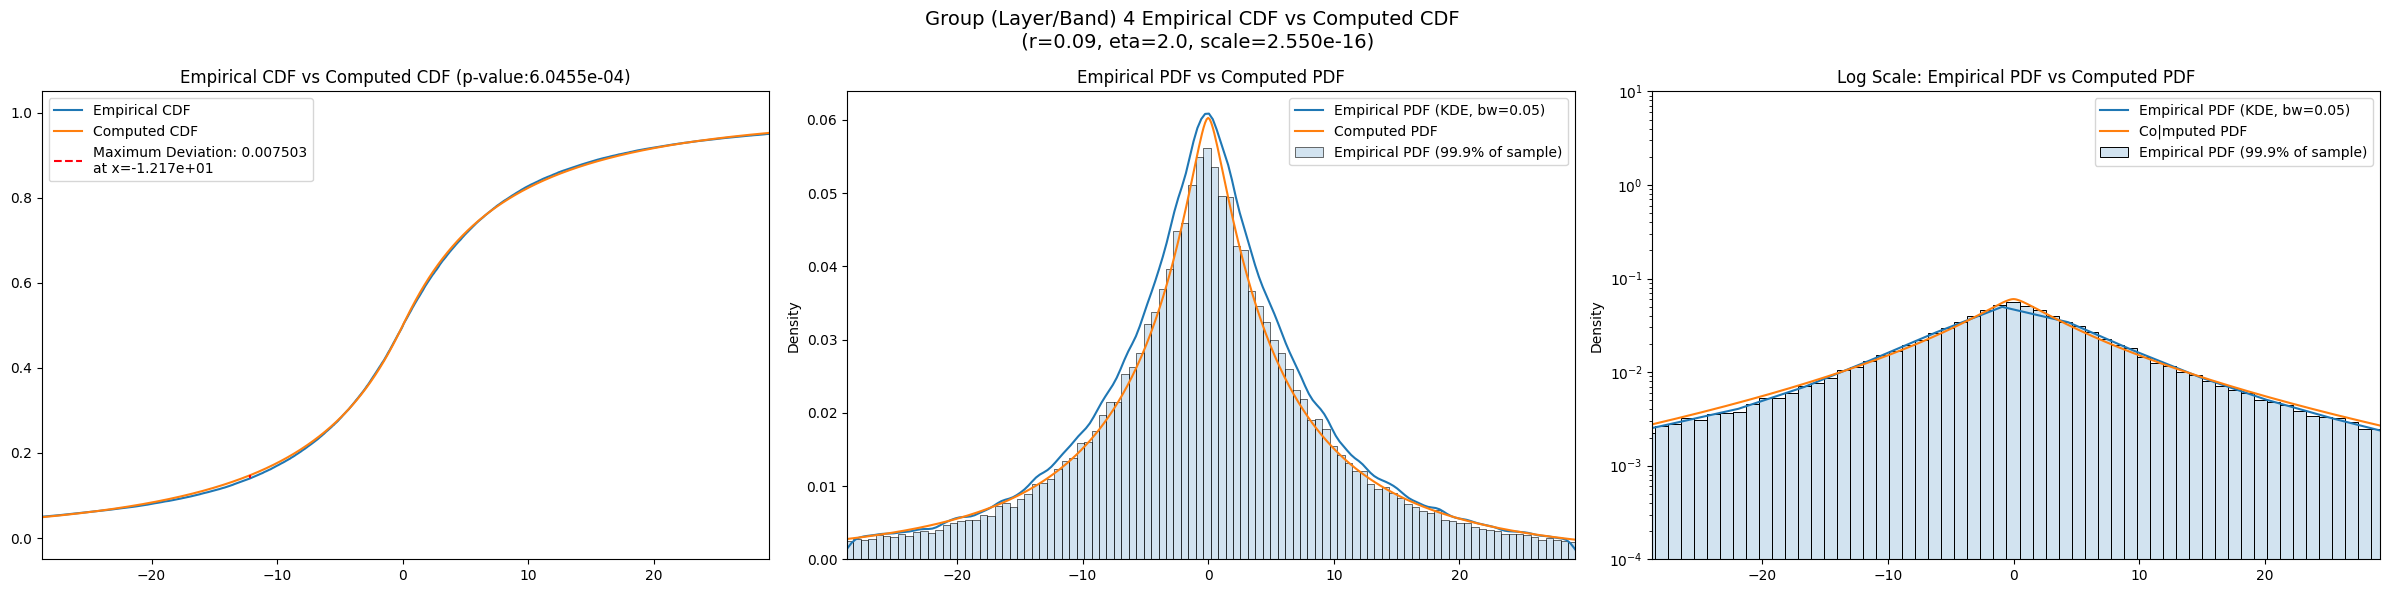

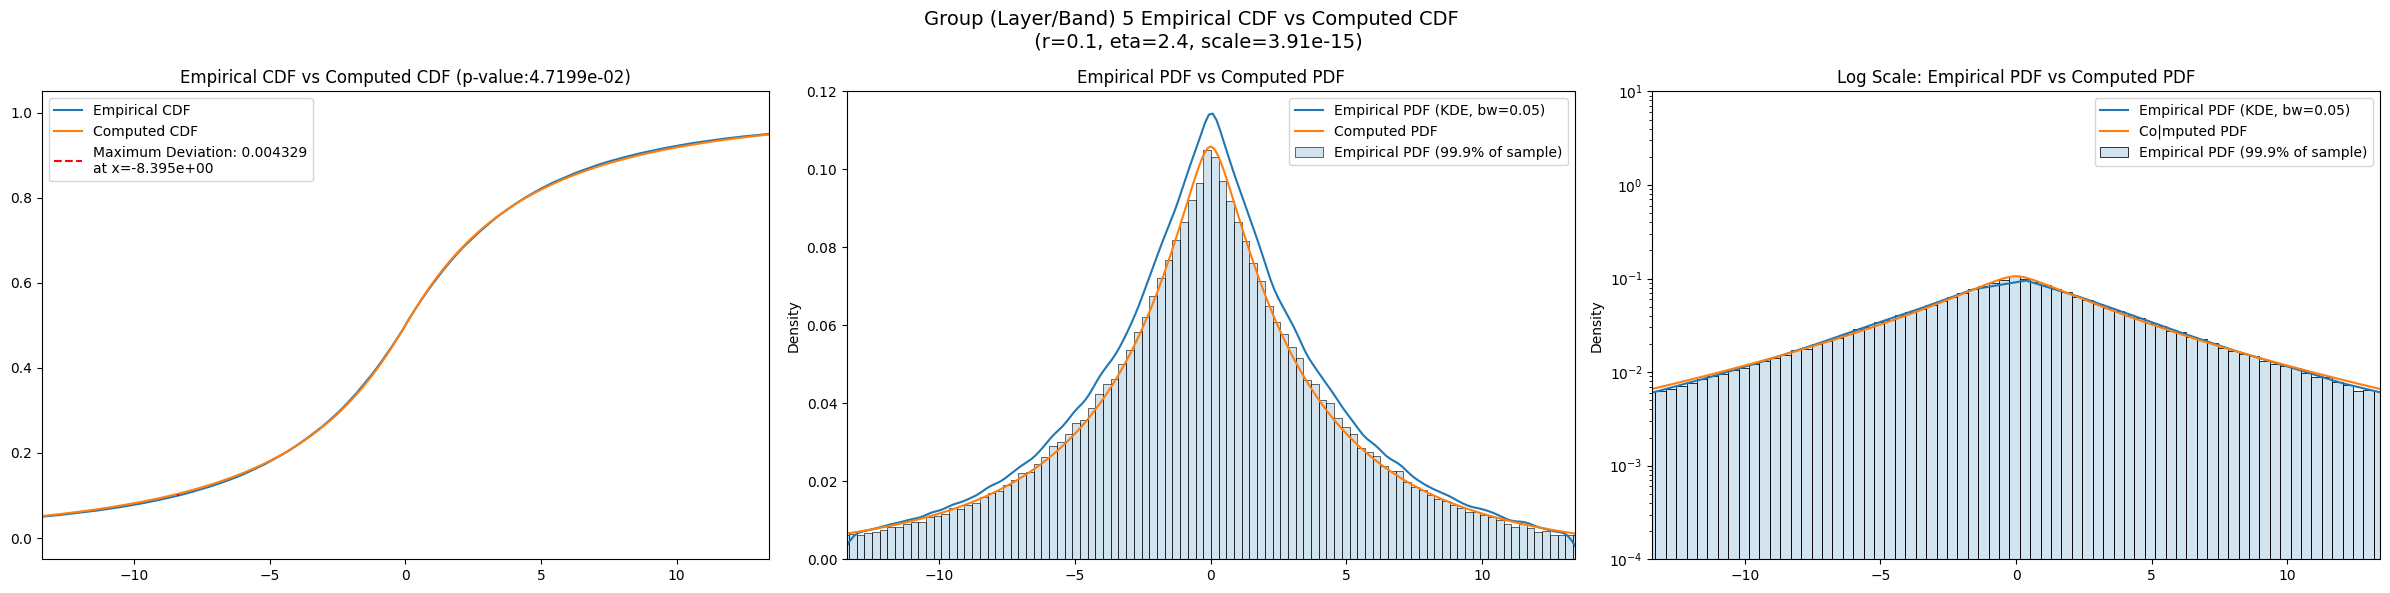

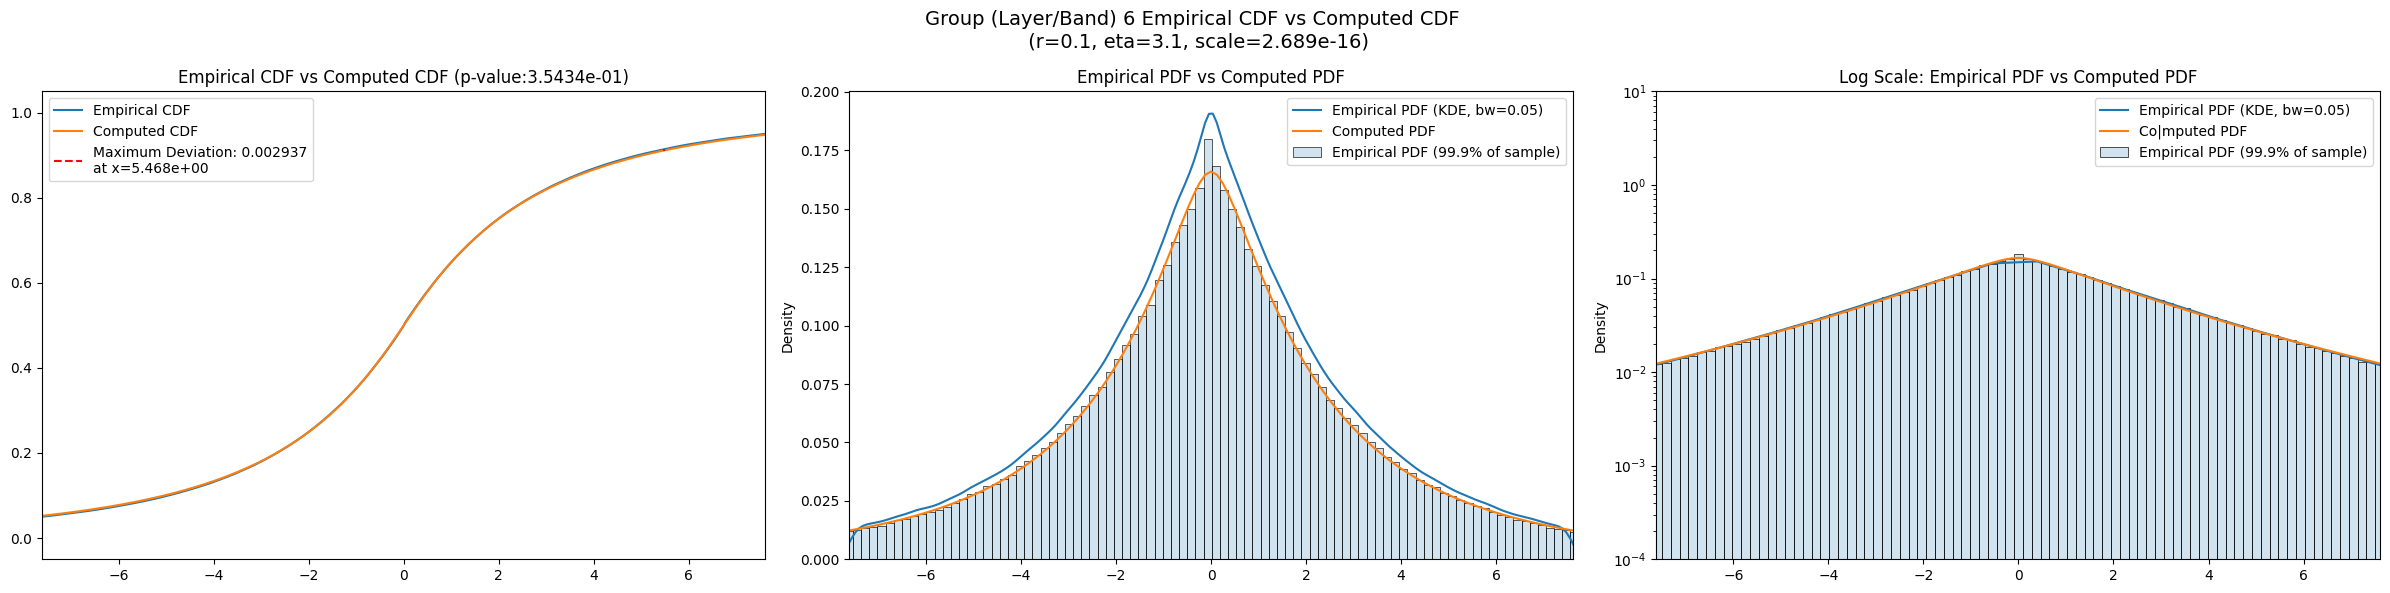

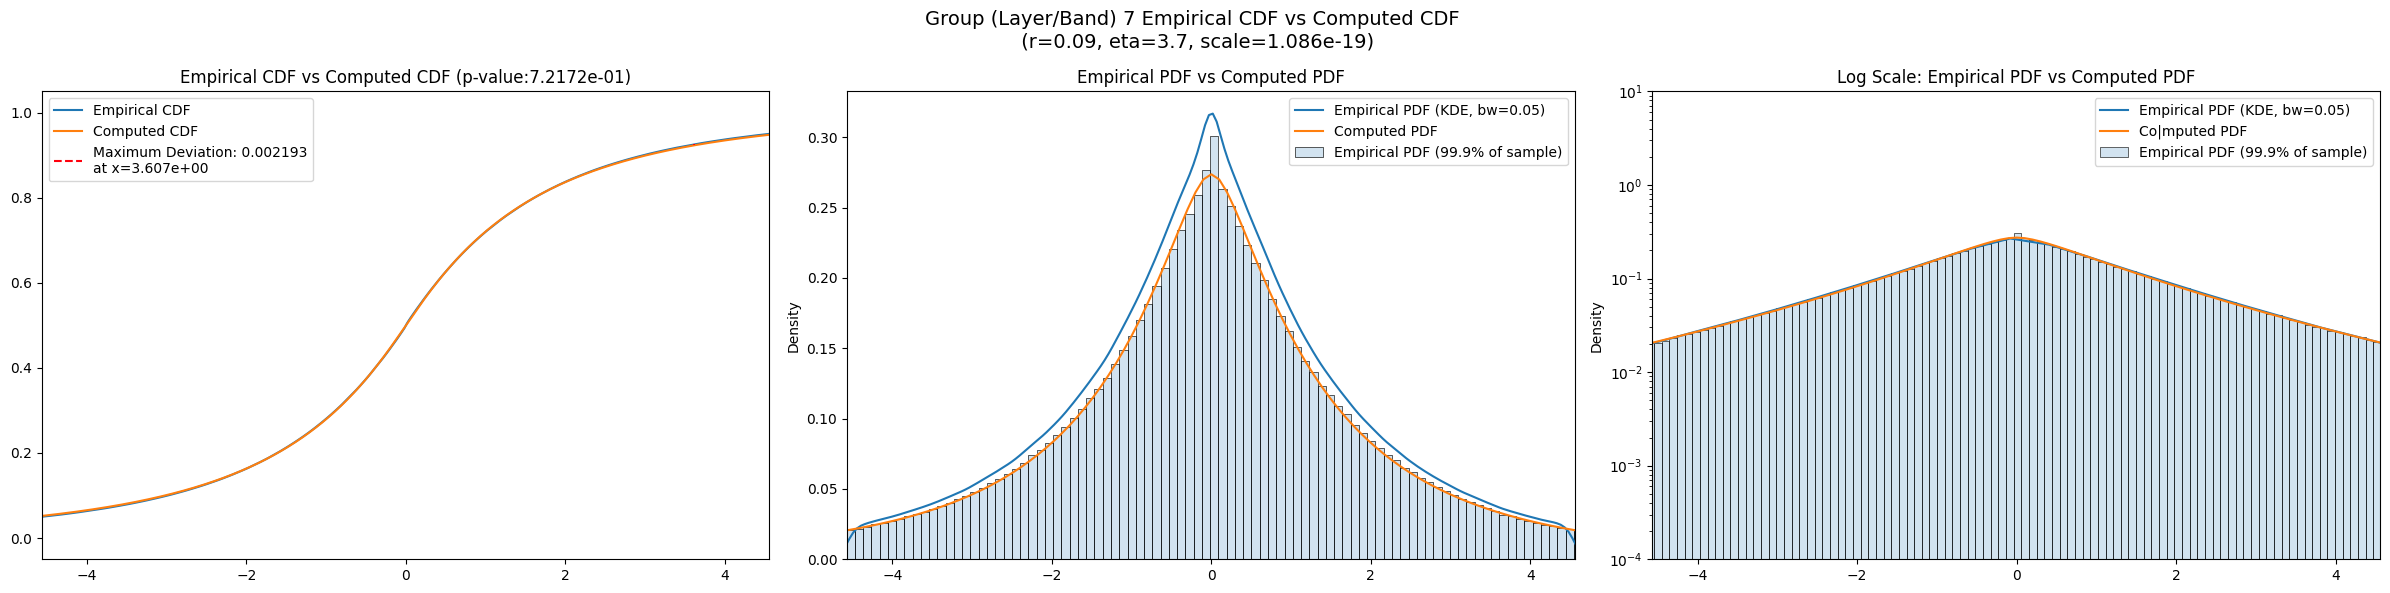

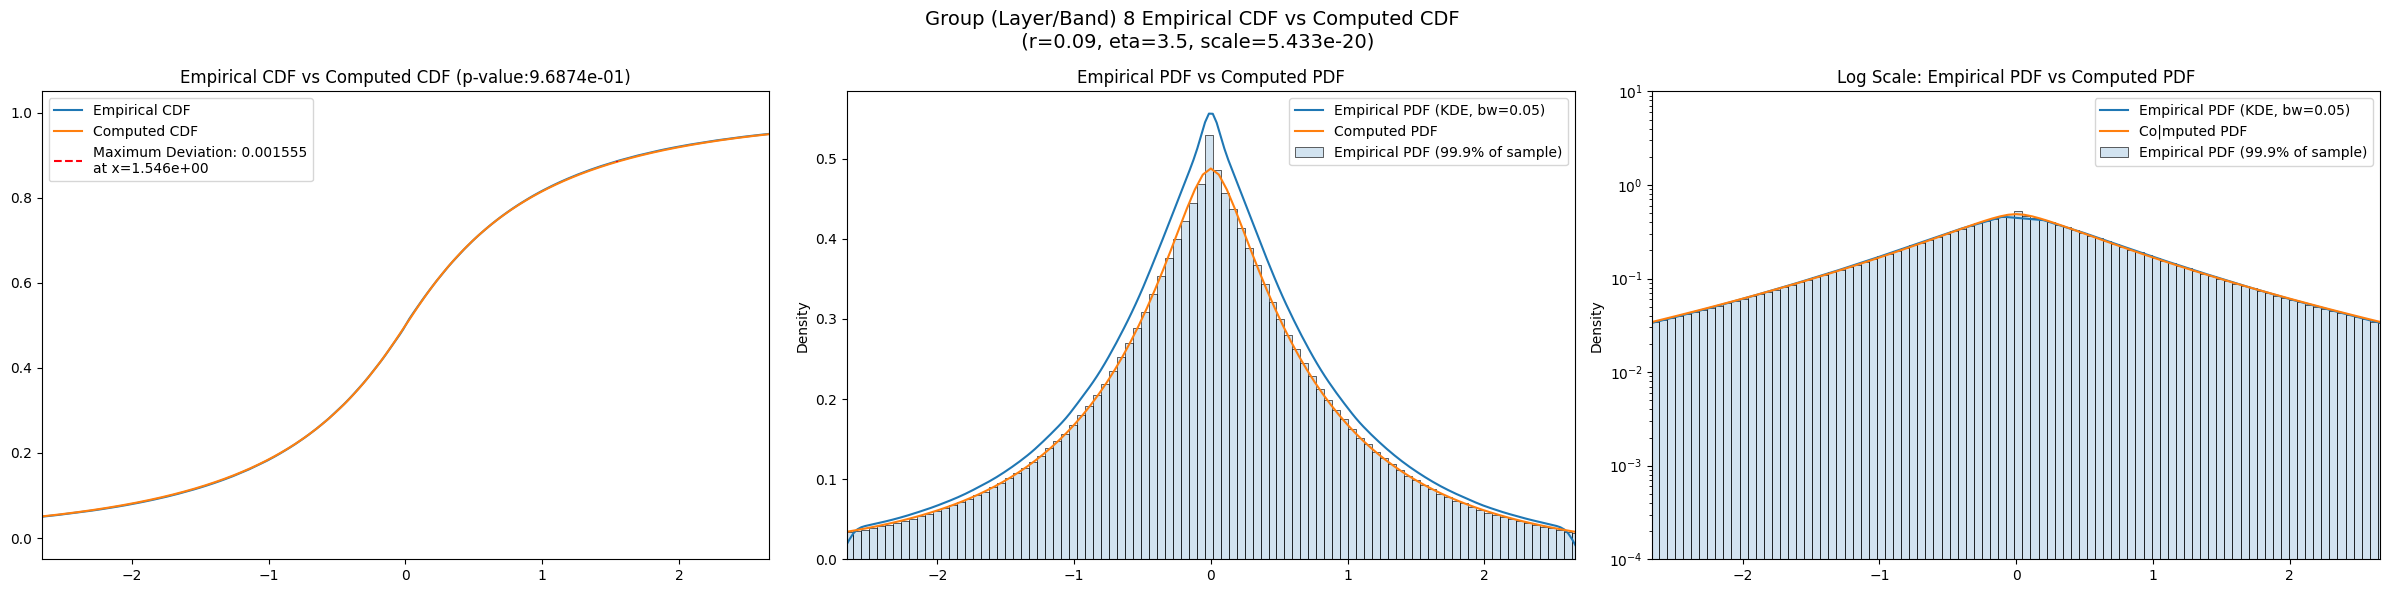

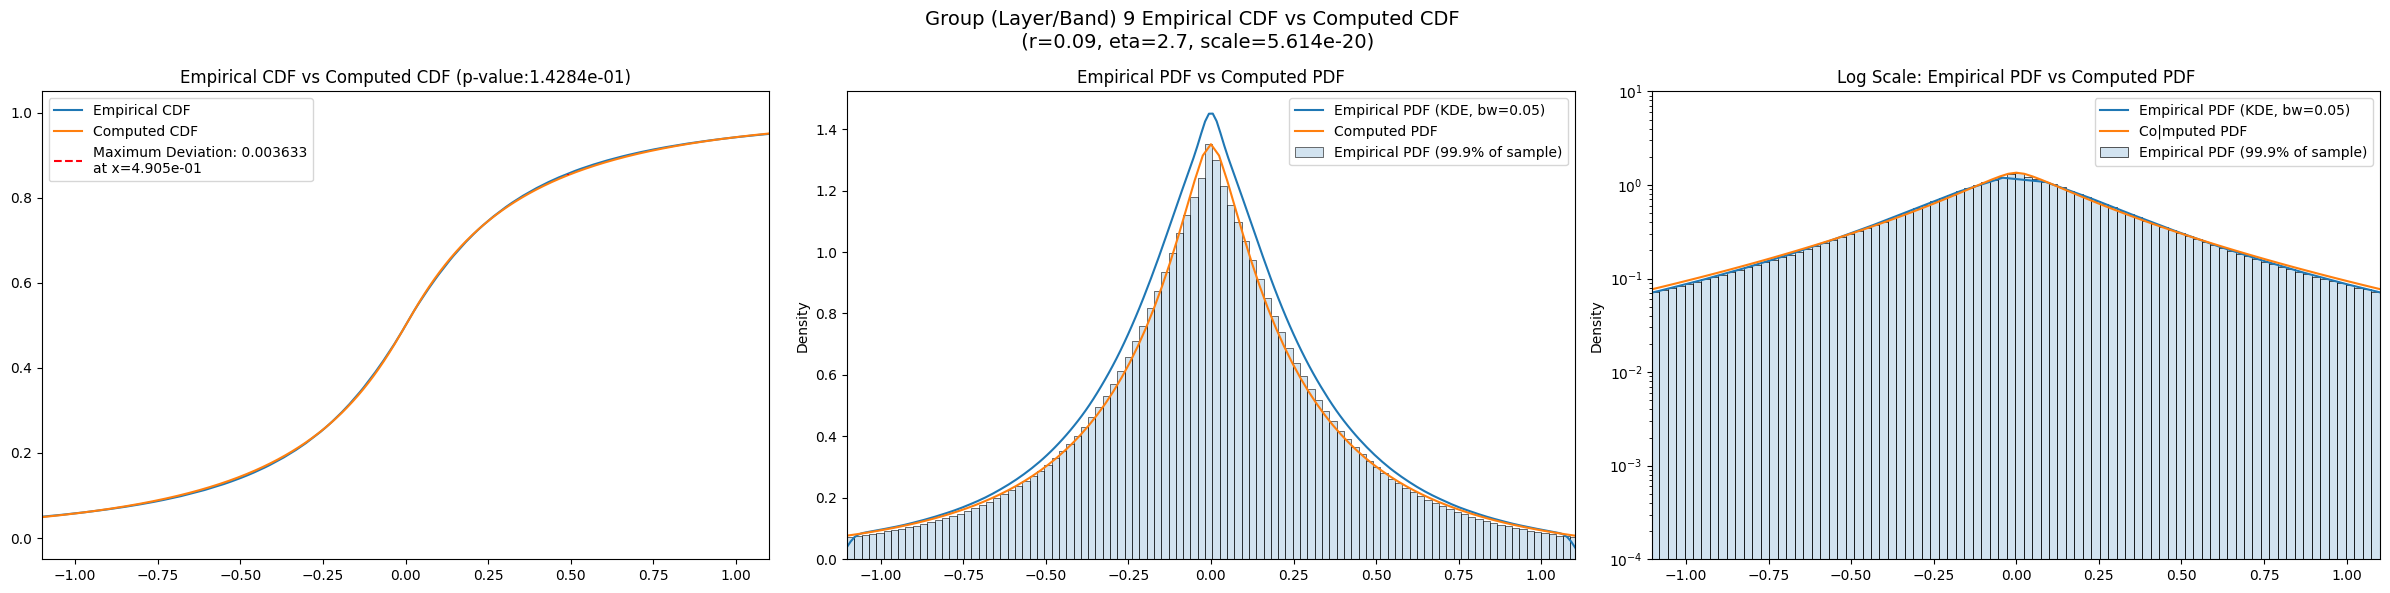

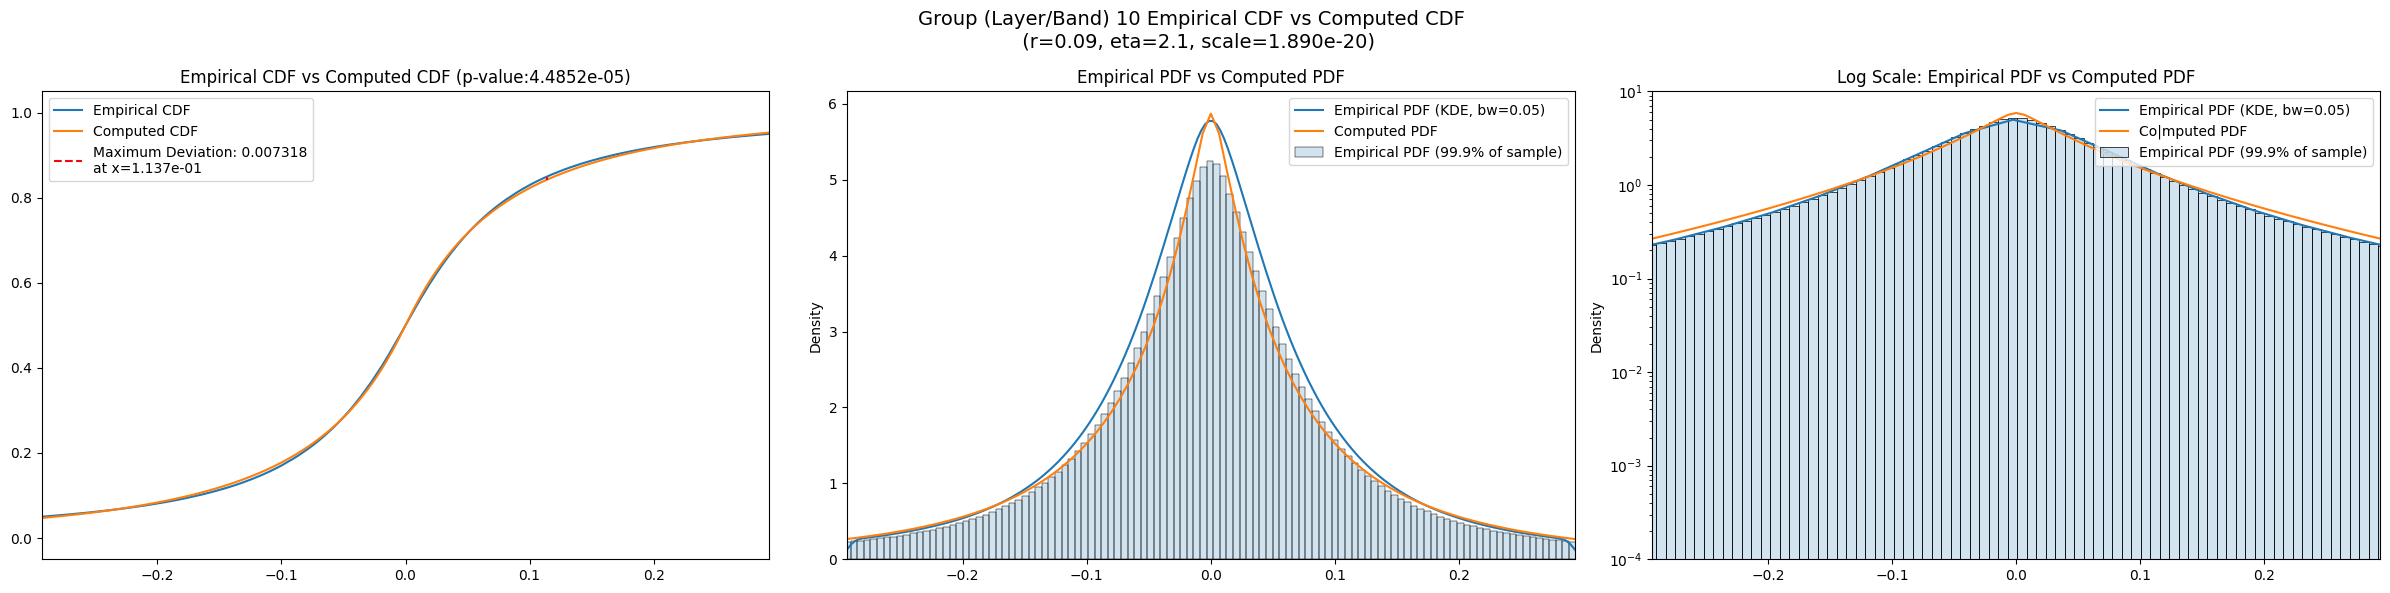

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      69813.110000  24438.908000  133779.030000   429.18650  234.234560   
3      11392.441000   6152.593300   18595.248000   457.30783  219.685730   
4       2179.918000   1035.629800    3992.716800   704.63410  168.132600   
5        346.023830    167.539300     702.062500   935.48710   96.572205   
6         86.537060     41.918427     230.855830  1742.35450   77.560530   
7         26.342790     13.104974      79.347130  2298.49900   57.908700   
8         10.249555      4.653888      33.031303  3021.93630   66.716064   
9          1.900417      0.877120       6.467205  3454.85030   64.006880   
10         0.176650      0.072993       0.811862  6309.32670   72.034730   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       710.59045         4500.0             0.015562        0.3         -0.4   
3       702.85030        18000.0             0.010201        0.1          1.4   
4      1193.39250        72000.0             0.007627        0.1          1.7   
5      1871.04700       288000.0             0.004172        0.1          2.4   
6      3937.45390      1152000.0             0.002514        0.1          3.1   
7      4520.91500      4608000.0             0.002065        0.1          3.5   
8      4910.34400     18432000.0             0.002083        0.1          3.1   
9      5167.04400     73728000.0             0.003944        0.1          2.4   
10     6579.15430    294912000.0             0.007512        0.1          1.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       58.493500              0.061328          3.723850e-15   
3      ...       24.975700              0.057230          1.096870e-51   
4      ...       11.310300              0.048901         4.581540e-150   
5      ...        5.826500              0.040405          0.000000e+00   
6      ...        3.465080              0.037016          0.000000e+00   
7      ...        2.086050              0.036577          0.000000e+00   
8      ...        1.191050              0.038347          0.000000e+00   
9      ...        0.463728              0.042862          0.000000e+00   
10     ...        0.114709              0.047376          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          51.584900             0.034876         3.433230e-05  40.980000   
3          22.053100             0.030388         7.116400e-15  17.360500   
4          10.091100             0.024196         4.754360e-37   7.895070   
5           5.191270             0.015312         4.405530e-59   4.084820   
6           3.062660             0.011263        2.267950e-127   2.453070   
7           1.840910             0.010171         0.000000e+00   1.482030   
8           1.051390             0.012205         0.000000e+00   0.842525   
9           0.411286             0.017639         0.000000e+00   0.325705   
10          0.102200             0.023391         0.000000e+00   0.080729   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.035052   3.073110e-05          3.199939e-01  
3           0.028918   1.644140e-13          6.811856e-02  
4           0.019265   1.210180e-23          1.088353e-03  
5           0.012106   4.291540e-37          8.835852e-05  
6           0.010340  2.054000e-107          9.499967e-07  
7           0.010189   0.000000e+00          8.509354e-13  
8           0.010799   0.000000e+00          7.389692e-51  
9           0.013354   0.000000e+00          0.000000e+00  
10          0.016832

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.015562                 0.020208          0.014216   
3                 0.010201                 0.010113          0.009680   
4                 0.007627                 0.005059          0.007222   
5                 0.004172                 0.002530          0.004172   
6                 0.002514                 0.001265          0.002514   
7                 0.002065                 0.000633          0.001758   
8                 0.002083                 0.000316          0.001775   
9                 0.003944                 0.000158          0.003479   
10                0.007512                 0.000079          0.006963   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.061328             0.034876       0.035052  
3                  0.057230             0.030388       0.028918  
4                  0.048901             0.024196       0.019265  
5                  0.040405             0.015312       0.012106  
6                  0.037016             0.011263       0.010340  
7                  0.036577             0.010171       0.010189  
8                  0.038347             0.012205       0.010799  
9                  0.042862             0.017639       0.013354  
10                 0.047376             0.023391       0.016832

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             9920.623047          0.014216    0.40     -0.64  7.409961e+02   
3             2126.888428          0.009680    0.12      1.10  4.431170e-09   
4              444.899841          0.007222    0.09      2.00  2.550257e-16   
5               92.795265          0.004172    0.10      2.40  3.909647e-15   
6               28.536780          0.002514    0.10      3.10  2.688661e-16   
7               10.221109          0.001758    0.09      3.70  1.086073e-19   
8                3.423624          0.001775    0.09      3.50  5.433363e-20   
9                0.603792          0.003479    0.09      2.70  5.613902e-20   
10               0.043585          0.006963    0.09      2.10  1.890336e-20   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                     75.0  
4                    225.0  
5                    250.0  
6                    150.0  
7                    100.0  
8                    125.0  
9                    175.0  
10                   275.0

In [21]:
eng.quit()